In [1]:
#import stuffs

import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from random import randint
import random

In [2]:
#borrowed from https://gist.github.com/pv/8036995

def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.
    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.
    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)



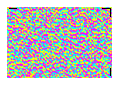

In [7]:
# generates Points
x = 36+1 #length of x axis, 1mm more than frame for mounting
dx = .5 #x size of average grain
y = 24+1 #length of y axis, 1mm more than frame for mounting
dy = .5 #average y meassure of grain
p = .8 #chance of an out of sequence color
alpha = 1 #transparency

random.seed(271) #make deterministic
plt.figure(figsize=(x*0.0393700787,y*0.0393700787)) 

points = []
for i in np.linspace(0,x,int(x/dx+1)):
    for j in np.linspace(0,y,int(y/dy+1)):
        rand_x = random.random()
        rand_x *= dx
        rand_y = random.random()
        rand_y *= dy
        points.append([rand_x+i,rand_y+j])

vor = Voronoi(points)


# generate regions
regions, vertices = voronoi_finite_polygons_2d(vor)

# colorize and plot
counter = 0
for region in regions:
    color = [1,1,1]
    color[counter%3] = 0
    counter += 1
    if random.random()>p:
        counter +=1
        
    polygon = vertices[region]
    plt.fill(*zip(*polygon), color = color, alpha=alpha)

# black out, makes sure we only see the frame
points = np.array([[0,0],[0,y],[-10,y],[-10,0]])
plt.fill(points[:,0],points[:,1],'k')
points = np.array([[x,0],[x,y],[x+10,y],[x+10,0]])
plt.fill(points[:,0],points[:,1],'k')


# make calibraiton marks
inset = .5 #mm distance into frame calibration marks are, add 1 for extra filter
thickness = .25 #mm thick marks are
length = 3 #mm long the marks are

pt_1 = np.array([[0+inset,0+inset], [0+inset, inset+length], [0+inset+thickness, inset+length], [0+inset+thickness,0+inset+thickness], [0+inset+length, 0+inset+thickness], [0+inset+length, 0+inset] ])
pt_2 = np.array([[x-inset,y-inset], [x-inset, y-inset-length], [x-inset-thickness, y-inset-length], [x-inset-thickness,y-inset-thickness], [x-inset-length, y-inset-thickness], [x-inset-length, y-inset] ])
plt.fill(pt_1[:,0],pt_1[:,1],'k')
plt.fill(pt_2[:,0],pt_2[:,1],'k')
plt.fill(pt_1[:,0],pt_2[:,1],'k')
plt.fill(pt_2[:,0],pt_1[:,1],'k')

#plt.plot(points[:,0], points[:,1], 'ko')

plt.axis('equal')
plt.xlim([0, x])
plt.ylim([0, y])
plt.axis('off')

#copied from https://stackoverflow.com/questions/11837979/removing-white-space-around-a-saved-image
#to get it to fill whole image
plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

#saving as a .png or .svg
plt.savefig('voro_CYM_0.5_1.svg', dpi=600,bbox_inches='tight',pad_inches = 0)
plt.show()